In [65]:
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors
import pathlib
import seaborn as sns
import time

In [139]:

class RecommendationSystem:
    """
    item-based collaborative filtering for movie-lens dataset using sklearn's nearest neighbors
    
    """
    def __init__(self,movie_th,user_th,movie_path,ratings_path,users_path):
        
        """
        Description:
            1. Initialization of threshold values
            2. Initialization of file paths
            3. Initialization of models
        
        """
        self.movie_th = movie_th
        self.user_th = user_th
        self.movies_path = movie_path
        self.ratings_path = ratings_path
        self.path = pathlib.Path().absolute() / 'ml-1m'
        self.users_path = users_path
        self.model = NearestNeighbors()
        self.data_matrix = None 
        self.dic_movie_name = None
        self.dic_movie_id = None
    def define_model_parameters(self,n_neighbors,algorithm,metric,jobs=1):
        
        #print(n_neighbors,algorithm,metric,jobs)
        """
        Args:
            n_neighbors : number of neighbors used for calculating similarity
            algorithm : type of algorithm used i.e brute force, KDTRee, BallTree for building model
            metric : how similarity is being measured i.e cosine, l1,l2 norm 
            jobs :  number of processors to be used in parallel
        """
        self.model.set_params(**{
            'n_neighbors':n_neighbors,
            'algorithm': algorithm,
            'metric': metric,
            'n_jobs' : jobs
        })
            
        
        
    def read_clean_prepare(self):
        
        
        
        self.ratings = pd.read_csv(
            self.path/self.ratings_path,
            sep='::',
            names=['userId','movieId','rating','timestamp'],
            usecols = ['userId','movieId','rating'],
            dtype= {'userId':np.int32,'movieId':np.int32,'rating':np.float32}
        )
        
        self.movies = pd.read_csv(
            self.path/self.movies_path,
            sep='::',
            names=['movieId','title','genres'],
            usecols = ['movieId','title'],
            dtype= {'movieId':np.int32,'title':str}
        )
        
        self.movies.title = self.movies.title.str.lower()
        self.movies['name'] = self.movies.title.str.replace(r'\(\d{4}\)',"")
        self.movies.name = self.movies.name.str.rstrip()
        self.dic_movie_name = dict([(row.movieId,row.title) for row in self.movies.itertuples()])
        self.dic_movie_id = dict([(row.name,row.movieId) for row in self.movies.itertuples()])
        temp = self.ratings.groupby('movieId').agg({'userId':len})
        self.pop_movies = temp[temp['userId']>=recommender.movie_th].index
        
        
        self.data_matrix = self.ratings.pivot(index = 'movieId',columns = 'userId', values = 'rating').fillna(0)
        
        self.data_matrix = csr_matrix(self.data_matrix)
        
        
        time.sleep(3)
        self.define_model_parameters(20,'brute','cosine')
        
        
        self.model.fit(self.data_matrix)
        
    def plot_rating_freq(self):
        temp = self.ratings.groupby('movieId').agg({'userId':len})

        #temp = temp.reset_index()
        temp = temp.sort_values(by=['userId'],ascending=False)
        temp.index = pd.RangeIndex(0,temp.shape[0])
        plt.plot(temp.index,temp['userId'])
        plt.title('movie rating frequency')
        plt.xlabel("movies")
        plt.ylabel("number of ratings")
        
        
    def recommend(self,fav,how_many):
        
        
        """
        Args:
        
            fav: name of favorite movie
            how_many : number of similar movies to be recommended
            
        Returns:
            
            Exits if the movie not in database else returns the name of the movies.
        
        """
        if fav not in self.dic_movie_id:
            print("Movie not found in the database\n")
            exit() 
        
        fav_id = self.dic_movie_id[fav]
        _,recommendations = self.model.kneighbors(self.data_matrix[fav_id],n_neighbors=how_many+1)
        
        recommendations = [self.dic_movie_name[x] for x in recommendations[0][1:]]
        #print(recommendations)
        print("Top {} recommendations are:\n".format(how_many))
        
        for i in range(how_many):
            
            print("{}. {}".format(i+1,recommendations[i]))
        return 

In [140]:
recommender = RecommendationSystem(50,50,'movies.dat','ratings.dat','users.dat')

In [141]:
recommender.read_clean_prepare()

20 brute cosine 1


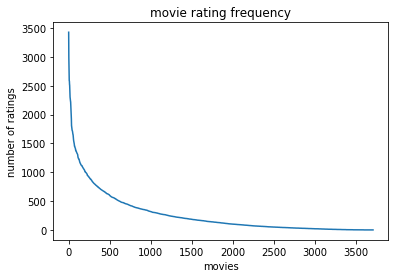

In [142]:
recommender.plot_rating_freq()

In [143]:
recommender.data_matrix.shape

(3706, 6040)

In [144]:
recommender.recommend('toy story',10)

Top 10 recommendations are:

1. patriot games (1992)
2. land and freedom (tierra y libertad) (1995)
3. postino, il (the postman) (1994)
4. mis�rables, les (1998)
5. friday the 13th part vii: the new blood (1988)
6. three colors: white (1994)
7. four weddings and a funeral (1994)
8. extreme measures (1996)
9. back to the future part iii (1990)
10. superweib, das (1996)
